# Packages and Configurations

In [1]:
import astro_util, os, re
import numpy as np
import pandas as pd
import astroalign as aa
import statsmodels.api as sm
from astropy.io import fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, PRFAdapter, IntegratedGaussianPRF
from matplotlib import pyplot as plt
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath, physics}")
plt.rc("font", family="serif", serif=["Computer Modern"])
plt.rc("axes", titlesize=20, labelsize=18)
plt.rc("figure", titlesize=20)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=10)

# Detect Dead Pixels

In [2]:
for filename in os.listdir("./data/master/"):
    substrs = filename.split('_')
    if "Dark" in substrs:
        for substr in substrs:
            if substr.endswith("1.0s"):
                dark1_master = fits.open("./data/master/" + filename)
                break

In [3]:
for filename in os.listdir("./data/master/"):
    substrs = filename.split('_')
    if "Dark" in substrs:
        for substr in substrs:
            if substr.endswith("5.0s"):
                dark5_master = fits.open("./data/master/" + filename)
                break

In [4]:
dark_medians = np.median(dark5_master[0].data, axis=(-1, -2))
dark_stds = np.std(dark5_master[0].data, axis=(-1, -2))

In [5]:
hot_thresholds = np.ceil(dark_medians + dark_stds)
while len(hot_thresholds.shape) < len(dark5_master[0].data.shape):
    hot_thresholds = np.expand_dims(hot_thresholds, axis=-1)
hot_pixels = dark5_master[0].data > hot_thresholds

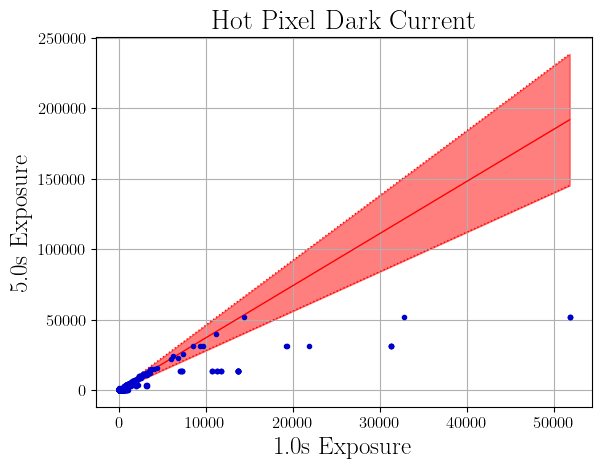

In [6]:
hot_pixel_dark1 = dark1_master[0].data[hot_pixels]
hot_pixel_dark5 = dark5_master[0].data[hot_pixels]
xline = [0, max(np.max(hot_pixel_dark1), np.max(hot_pixel_dark5))]
yline = [0, 3.7 * xline[1]]
yline_top = [0, 4.6 * xline[1]]
yline_bottom = [0, 2.8 * xline[1]]

plt.plot(xline, yline, lw=1, c="red")
plt.plot(xline, yline_top, lw=1, c="red", ls="dotted")
plt.plot(xline, yline_bottom, lw=1, c="red", ls="dotted")
plt.fill_between(xline, yline_bottom, yline_top,
                 color="red", alpha=0.5)

plt.plot(hot_pixel_dark1, hot_pixel_dark5, marker='o',
         ms=3, lw=0, color="mediumblue")

plt.xlabel("1.0s Exposure")
plt.ylabel("5.0s Exposure")
plt.title("Hot Pixel Dark Current")
plt.grid()

plt.savefig("fig/hotpix.png", bbox_inches="tight", dpi=300)
plt.show()

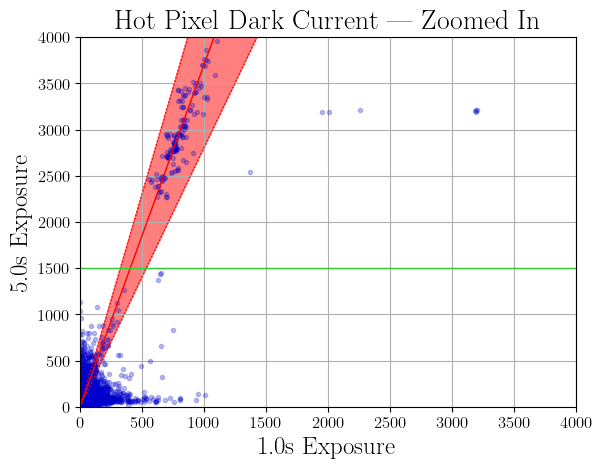

In [7]:
plt.plot(hot_pixel_dark1, hot_pixel_dark5, marker='o',
         ms=3, lw=0, color="mediumblue", alpha=0.25)

plt.plot(xline, yline, lw=1, c="red")
plt.plot(xline, yline_top, lw=1, c="red", ls="dotted")
plt.plot(xline, yline_bottom, lw=1, c="red", ls="dotted")
plt.fill_between(xline, yline_bottom, yline_top,
                 color="red", alpha=0.5)
plt.axhline(1500, lw=1, c="limegreen")

plt.xlim(0, 4000)
plt.ylim(0, 4000)
plt.grid()

plt.xlabel("1.0s Exposure")
plt.ylabel("5.0s Exposure")
plt.title("Hot Pixel Dark Current --- Zoomed In")

plt.savefig("fig/hotpix_zoom.png", bbox_inches="tight", dpi=300)
plt.show()

In [8]:
dark_mask = ((dark5_master[0].data > 1500)
             & ((dark5_master[0].data < 2.8 * dark1_master[0].data)
                | (dark5_master[0].data > 4.6 * dark1_master[0].data)))

In [9]:
dark_grayscale_mask = np.sum(dark_mask, axis=0) != 0

In [ ]:
dark5_master.close()
dark1_master.close()

# Alignment

In [ ]:
filename = os.listdir("./data/single/")[0]
reference = fits.open("./data/single/" + filename)[0].data
reference = np.ma.array(astro_util.srgb_to_grayscale(reference),
                        mask=dark_grayscale_mask).astype(np.float32)
stacked = np.zeros_like(reference)

for filename in os.listdir("./data/single/"):
    data = fits.open("./data/single/" + filename)[0].data
    data = np.ma.array(astro_util.srgb_to_grayscale(data),
                       mask=dark_grayscale_mask).astype(np.float32)
    registered, _ = aa.register(data, reference)
    stacked += registered

In [ ]:
header = fits.open("./data/single/" + filename)[0].header
name = filename.split('_')
for (i, substr) in enumerate(name):
    if bool(re.fullmatch("[0-9]+\.?[0-9]*s", substr)):
        name[i] = str(len(os.listdir("./data/single/"))) + 'x' + substr
    if bool(re.fullmatch("[0-9]+T[0-9]+\.fits", substr)):
        name[i] = substr.split('T')[0] + ".fits"
    if bool(re.fullmatch("[0-9]+T[0-9]+", substr)):
        name[i] = substr.split('T')[0]
fits.PrimaryHDU(data=stacked[300:3150, 300:4800], header=astro_util.build_master_header(
        header, len(os.listdir("./data/single/")))
    ).writeto("./data/master/" + '_'.join(name), overwrite=True)

# Photometry

In [11]:
for filename in os.listdir("./data/master/"):
    if "DoubleCluster" in filename.split('_'):
        stacked = fits.open("./data/master/" + filename)[0].data

median = np.median(stacked)
std = np.std(stacked)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std+median)

psf_model = IntegratedGaussianPRF(
    fixed={'flux':False, 'x_0':False,
           'y_0':False, 'sigma':False})
psfphot = PSFPhotometry(psf_model, (7, 7), finder=daofind,
                        aperture_radius=4)
photometry = psfphot(stacked - median)

xs, ys = np.array(photometry["x_fit"]), np.array(photometry["y_fit"])
refidx = np.argmin((xs - 2105.45)**2 + (ys - 1395.71)**2)

mag = -2.5 * np.log10(np.array(photometry["flux_fit"]))
mag = 7.96 + mag - mag[refidx]

error = 1.08 * (np.array(photometry["flux_err"])
                / np.array(photometry["flux_fit"]))
error += error[refidx]
error[refidx] /= 2

sorted_indices = mag.argsort()
pd.DataFrame({"id" : range(1, len(mag) + 1),
              'x' : xs[sorted_indices], 'y' : ys[sorted_indices],
              "mag" : mag[sorted_indices], "error" : error[sorted_indices]}
             ).to_csv("./data/psfphotometry.csv", index=False)

In [14]:
df = pd.read_csv("data/psfphotometry.csv")
pd.DataFrame({"id" : df["id"][:10],
              'x' : np.round(df['x'], 2)[:10], 'y' : np.round(df['y'], 2)[:10],
              "mag" : np.round(df['mag'], 2)[:10], "error" : np.round(df['error'], 2)[:10]}
             ).to_csv("./data/selected.csv", index=False)

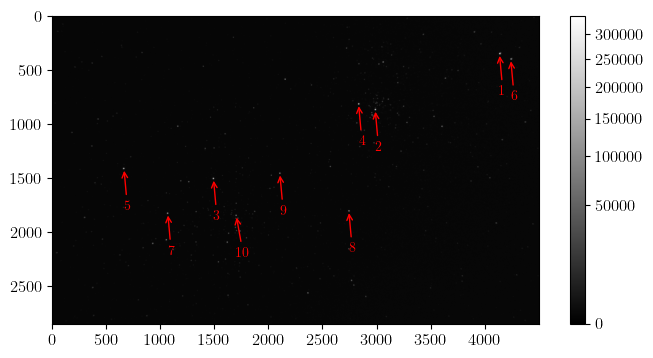

In [16]:
df = pd.read_csv("data/selected.csv")
for filename in os.listdir("./data/master/"):
    if "DoubleCluster" in filename.split('_'):
        stacked = fits.open("./data/master/" + filename)[0].data

fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(stacked, cmap="gray",
    norm=ImageNormalize(stretch=SqrtStretch()))
fig.colorbar(im)

for star_id in df["id"]:
    ax.annotate(str(star_id), (df['x'][star_id - 1], df['y'][star_id - 1]),
                (0, -30), textcoords="offset points", color="red",
                arrowprops=dict(arrowstyle="->", color="red"))

plt.savefig("fig/cluster.pdf", bbox_inches="tight", dpi=300)
plt.show()